In [18]:
import pandas as pd
import pandas as pd
import numpy as np
import ast  # For safe evaluation of Python-like strings
from transformers import BertTokenizer
import pickle as pkl
from dataset import RedlistDataset
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
from transformers import AdamW
from model_tax import RedlistPredictor
from tqdm import tqdm
from transformers import get_scheduler
import os
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [19]:
with open("data/data_splits.pkl", "rb") as f:
    data = pkl.load(f)
    unknown_values = pkl.load(f)

df_train = data["train"]
df_test = data["test"]
df_deficient = data["deficient"]

In [3]:
textural_cols = ['rationale', 'habitat', 'threats', 'population', 'range', 'useTrade', 'conservationActions']
for col in textural_cols:
    unknown_values[col] = 'no information'

In [4]:
# df_pseudoDD = df_test.copy()

In [4]:
with open("data/pseudoDD", "rb") as f:
    df_pseudoDD = pkl.load(f)
    pseo_preds = pkl.load(f)

In [17]:
for r in df_pseudoDD['rationale']:
    print(r)

this widely distributed, reef species is reasonably common. there are no known major threats; therefore, it is listed as Data Deficient with a recommendation to monitor the potential impact from the marine ornamental trade.
this rocky-reef species is known from three specimens collected from three widely-scattered localities off southern australia in 1914 and new zealand in 2004 and 2012. there are no known major threats; therefore, it is listed as Data Deficient.
listed as Data Deficient in view of its wide distribution, presumed large population, and because it is unlikely to be declining fast enough to qualify for listing in a more threatened category.
although its extent of occurrence (eoo) is only 12,873 km 2 , it is common, adaptable, and does not appear to be in significant decline.
cebus olivaceus is considered Data Deficient (lc). according to global forest watch data for those regions of venezuela, guyana and brazil in which this species occurs, projected forest loss over the

In [7]:
df_pseudoDD['rationale'] = df_pseudoDD.apply(
    lambda row: row['rationale'].replace('[REDACTED]', 'Data Deficient'),
    axis=1
)

In [6]:
fractions = {}

for col in unknown_values.keys():
    fracs = []
    for df_split in [df_train, df_pseudoDD, df_deficient]:
        if col in textural_cols:
            # Compare strings
            # match_fraction = len(df_split[df_split[col]==unknown_values[col]]) / len(df_split)
            match_fraction = df_split[col].str.lower().apply(lambda x: x == 'no information' or any(substring in x for substring in ['no information', 'unknown', 'not known'])).mean()
        elif col in ['populationTrend', 'possiblyExtinct', 'possiblyExtinctInTheWild']:
            # Compare floats with 1e-5 tolerance
            match_fraction = (abs(df_split[col] - unknown_values[col]) < 1e-5).mean()
        else:
            # Compare numpy arrays
            match_fraction = df_split[col].apply(lambda x: np.array_equal(x, unknown_values[col])).mean()
        fracs.append(match_fraction)
    
    fractions[col] = fracs

fractions

{'populationTrend': [0.5044352105619898,
  0.9515558698727016,
  0.9539176139836206],
 'realm_vector': [0.20478590162968202,
  0.25624705327675623,
  0.2679379049016013],
 'systems_vector': [0.0, 0.0, 0.0],
 'possiblyExtinct': [0.0, 0.0, 0.0],
 'possiblyExtinctInTheWild': [0.0, 0.0, 0.0],
 'rationale': [0.05275100934193853, 0.20462046204620463, 0.21329910768854662],
 'habitat': [0.0634780302360534, 0.132013201320132, 0.13629140691846964],
 'threats': [0.09433295022544426, 0.49222065063649223, 0.5344089964552011],
 'population': [0.20245778445760765, 0.3609146628948609, 0.3995844028847329],
 'range': [0.02410632717413727, 0.061291843470061294, 0.061850629507395186],
 'useTrade': [0.07856658709810509, 0.1379066478076379, 0.11758953673145092],
 'conservationActions': [0.07818347920902956,
  0.14933993399339934,
  0.15633785600782302]}

In [7]:
# Compare the two DataFrames column by column and count the number of differing cells
# num_differing_cells = 0

# for col in df_test.columns:
# 	if df_test[col].dtype == 'object':  # Handle object columns
# 		num_differing_cells += (df_test[col].apply(str) != df_pseudoDD[col].apply(str)).sum()
# 	elif df_test[col].dtype == 'float64' or df_test[col].dtype == 'int64':  # Handle numeric columns
# 		num_differing_cells += (df_test[col] != df_pseudoDD[col]).sum()
# 	else:  # Handle array-like columns
# 		num_differing_cells += df_test[col].apply(lambda x: not np.array_equal(x, df_pseudoDD.loc[x.name, col])).sum()

# print(f"Number of differing cells: {num_differing_cells}")

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
tax_vocab_size = {
    'className_idx': 8,
    'orderName_idx': 101,
    'familyName_idx': 878,
    'genusName_idx': 7618
}

model = RedlistPredictor(
    bert_model_name='bert-base-uncased',
    structured_input_dim=len(df_train.iloc[0]['structured_vector']),
    taxonomy_vocab_sizes=tax_vocab_size,
    hidden_dim=256,
    num_classes=6,
).to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()

/home/fs01/ym277/miniconda3/envs/dam/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/home/fs01/ym277/miniconda3/envs/dam/lib/python3.8/site-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [9]:
def evaluate(model, loader, criterion):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(loader):
            # print(batch.keys())
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            structured_input = batch['structured_input'].to(device)
            labels = batch['label'].to(device)
            taxonomy = batch['taxonomy'].to(device)

            logits = model(input_ids, attention_mask, structured_input, taxonomy)
            loss = criterion(logits, labels)
            total_loss += loss.item()

            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(loader)
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='macro', zero_division=0
    )

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"Loss: {avg_loss:.4f}")

    return {
        'loss': avg_loss,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }, all_preds


In [11]:
checkpoint_path = f"checkpoints_no_redact/checkpoint_epoch_3.pt"
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

RedlistPredictor(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_

In [12]:
def parse_vector_string(v):
    # Handles strings like "[1 0 0]" → array([1, 0, 0])
    return np.array([int(i) for i in v.strip('[]').split()], dtype=np.int32)

# Load CSV
# df = pd.read_csv("data/df_processed.csv")  # replace with actual path

# Parse vectors
# df['realm_vector'] = df['realm_vector'].apply(parse_vector_string)
# df['systems_vector'] = df['systems_vector'].apply(parse_vector_string)

# Combine structured features into one array
df_pseudoDD['structured_vector'] = df_pseudoDD.apply(
    lambda row: np.concatenate([
        np.array([row['populationTrend']]), 
        np.array([row['possiblyExtinct']]), 
        np.array([row['possiblyExtinctInTheWild']]), 
        row['realm_vector'], 
        row['systems_vector']
    ]),
    axis=1
)

text_cols = ['rationale', 'habitat', 'threats', 'population', 'range', 'useTrade', 'conservationActions']
df_pseudoDD['text_input'] = df_pseudoDD[text_cols].fillna("No information").agg(" [SEP] ".join, axis=1)

In [13]:
taxonomy_levels=['className_idx', 'orderName_idx', 'familyName_idx', 'genusName_idx']
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_dataset = RedlistDataset(df_train, tokenizer, taxonomy_levels)
test_dataset = RedlistDataset(df_test, tokenizer, taxonomy_levels)
pseodoDD_dataset = RedlistDataset(df_pseudoDD, tokenizer, taxonomy_levels)


batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)
pseodoDD_loader = DataLoader(pseodoDD_dataset, batch_size=16)

/home/fs01/ym277/miniconda3/envs/dam/lib/python3.8/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [14]:
pseodo_res, pseo_preds = evaluate(model, pseodoDD_loader, criterion)

100%|██████████| 531/531 [02:14<00:00,  3.94it/s]

Accuracy: 0.9257
Precision: 0.8461
Recall: 0.8342
F1 Score: 0.8388
Loss: 0.2623


In [16]:
label_to_category = {
    0: 'Least Concern',
    1: 'Near Threatened',
    2: 'Vulnerable',
    3: 'Endangered',
    4: 'Critically Endangered',
    5: 'Extinct'
}

In [17]:
class_labels = [f'{id}: {label_to_category[id]}' for id in range(6)]

def plot_confusion_matrix(true_labels, predicted_labels, is_normalized, title_str=''):
    
    if is_normalized:
        cm = confusion_matrix(true_labels, predicted_labels, normalize='true')
    else:
        cm = confusion_matrix(true_labels, predicted_labels)

    # Plot the confusion matrix
    plt.figure(figsize=(10, 8))
    
    sns.heatmap(cm, annot=True, fmt=".3f", cmap="Blues", xticklabels=range(6), yticklabels=class_labels)

    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    if is_normalized:
        plt.title("Confusion Matrix (Normalized)"+title_str)
    else:
        plt.title("Confusion Matrix (Raw Counts)"+title_str)
    plt.show()

In [19]:
test_true_labels = [sample['label'] for sample in test_dataset]

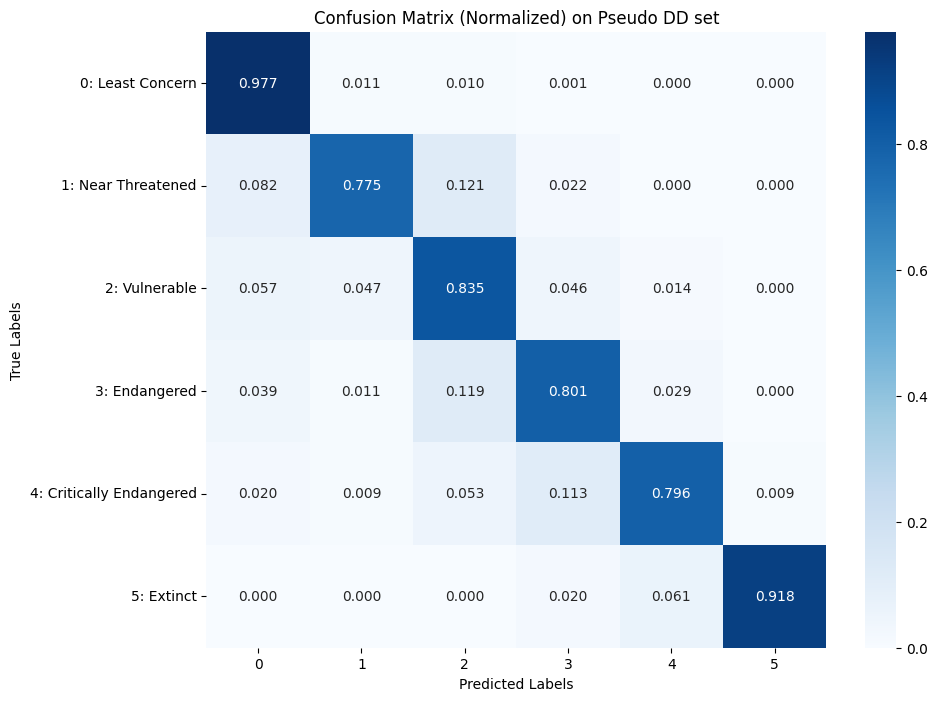

In [20]:
plot_confusion_matrix(test_true_labels, pseo_preds, is_normalized=True, title_str=' on Pseudo DD set')

In [70]:
with open('data/pseudoDD', 'wb') as f:
    pkl.dump(df_pseudoDD, f)
    pkl.dump(pseo_preds, f)
    